In [1]:
# Import libraries
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from data_preprocessing import load_data
from feature_extraction import FeatureExtractor
from train_model import prepare_train_test_split
from evaluate_model import ModelEvaluator

import warnings
warnings.filterwarnings('ignore')

print("✅ All modules imported successfully!")

✅ All modules imported successfully!


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\param\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Load Processed Data

In [2]:
# Load cleaned data
df = load_data('../data/processed/cleaned_reviews.csv')
print(f"Loaded {len(df)} reviews")

# Remove rows with NaN or empty cleaned_review
print(f"\n🔍 Original dataset size: {len(df)}")
df = df[df['cleaned_review'].notna() & (df['cleaned_review'].str.strip() != '')].reset_index(drop=True)
print(f"✅ After removing empty reviews: {len(df)}")

df.head()

✅ Loaded 140320 reviews from ../data/processed/cleaned_reviews.csv
Loaded 140320 reviews

🔍 Original dataset size: 140320
✅ After removing empty reviews: 135939


,CourseId,Review,Label,cleaned_review
0,2-speed-it,BOring,1,boring
1,2-speed-it,Bravo !,5,bravo
2,2-speed-it,Very goo,5,goo
3,2-speed-it,"Great course - I recommend it for all, especia...",5,great course recommend especially business man...
4,2-speed-it,One of the most useful course on IT Management!,5,one useful course management


## 2. Feature Extraction

In [3]:
# Load saved vectorizer or create new one
import joblib

# Convert ratings to sentiment if needed
if 'sentiment' not in df.columns and 'Label' in df.columns:
    print("\n🔄 Converting ratings to sentiment labels...")
    def rating_to_sentiment(rating):
        if rating >= 4:
            return 'Positive'
        elif rating <= 2:
            return 'Negative'
        else:
            return 'Neutral'
    df['sentiment'] = df['Label'].apply(rating_to_sentiment)
    print("✅ Conversion complete!")
    print(f"Sentiment distribution:\n{df['sentiment'].value_counts()}")

# Extract features
try:
    extractor = FeatureExtractor()
    extractor.load_vectorizer('../models/tfidf_vectorizer.pkl')
    X = extractor.transform(df['cleaned_review'])
except:
    print("Creating new vectorizer...")
    extractor = FeatureExtractor(method='tfidf', max_features=5000, ngram_range=(1, 2))
    X = extractor.fit_transform(df['cleaned_review'])

y = df['sentiment']  # Use sentiment labels

print(f"\nFeature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"\nLabel distribution:\n{y.value_counts()}")


🔄 Converting ratings to sentiment labels...
✅ Conversion complete!
Sentiment distribution:
sentiment
Positive    124855
Neutral       5781
Negative      5303
Name: count, dtype: int64
✅ Vectorizer loaded from ../models/tfidf_vectorizer.pkl

Feature matrix shape: (135939, 5000)
Labels shape: (135939,)

Label distribution:
sentiment
Positive    124855
Neutral       5781
Negative      5303
Name: count, dtype: int64


In [4]:
# Split data
X_train, X_test, y_train, y_test = prepare_train_test_split(X, y, test_size=0.2, random_state=42)


📊 Data Split:
   Training samples: 108751
   Testing samples: 27188
   Features: 5000


## 3. Hyperparameter Tuning - Logistic Regression

In [7]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000, 2000]
}

# Initialize model
lr = LogisticRegression(random_state=42)

# Grid search
print("🔍 Performing Grid Search for Logistic Regression...")
grid_lr = GridSearchCV(
    lr,
    param_grid_lr,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_lr.fit(X_train, y_train)

print(f"\n✅ Best parameters: {grid_lr.best_params_}")
print(f"✅ Best cross-validation score: {grid_lr.best_score_:.4f}")
print(f"✅ Test accuracy: {grid_lr.score(X_test, y_test):.4f}")

🔍 Performing Grid Search for Logistic Regression...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

✅ Best parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
✅ Best cross-validation score: 0.9295
✅ Test accuracy: 0.9307


## 4. Hyperparameter Tuning - Random Forest

In [9]:
# Define parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use RandomizedSearchCV for faster results
rf = RandomForestClassifier(random_state=42)

print("🔍 Performing Randomized Search for Random Forest...")
random_rf = RandomizedSearchCV(
    rf,
    param_grid_rf,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_rf.fit(X_train, y_train)

print(f"\n✅ Best parameters: {random_rf.best_params_}")
print(f"✅ Best cross-validation score: {random_rf.best_score_:.4f}")
print(f"✅ Test accuracy: {random_rf.score(X_test, y_test):.4f}")

🔍 Performing Randomized Search for Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
✅ Best cross-validation score: 0.9216
✅ Test accuracy: 0.9233


## 5. Try Gradient Boosting

In [10]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

print("🚀 Training Gradient Boosting Classifier...")
gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

gb.fit(X_train, y_train)

print(f"\n✅ Training accuracy: {gb.score(X_train, y_train):.4f}")
print(f"✅ Test accuracy: {gb.score(X_test, y_test):.4f}")

🚀 Training Gradient Boosting Classifier...

✅ Training accuracy: 0.9333
✅ Test accuracy: 0.9260


## 6. Compare Optimized Models


📊 Model Comparison:
                               Train Accuracy  Test Accuracy
Optimized Logistic Regression        0.936883       0.930668
Optimized Random Forest              0.995605       0.923275
Gradient Boosting                    0.933343       0.925997


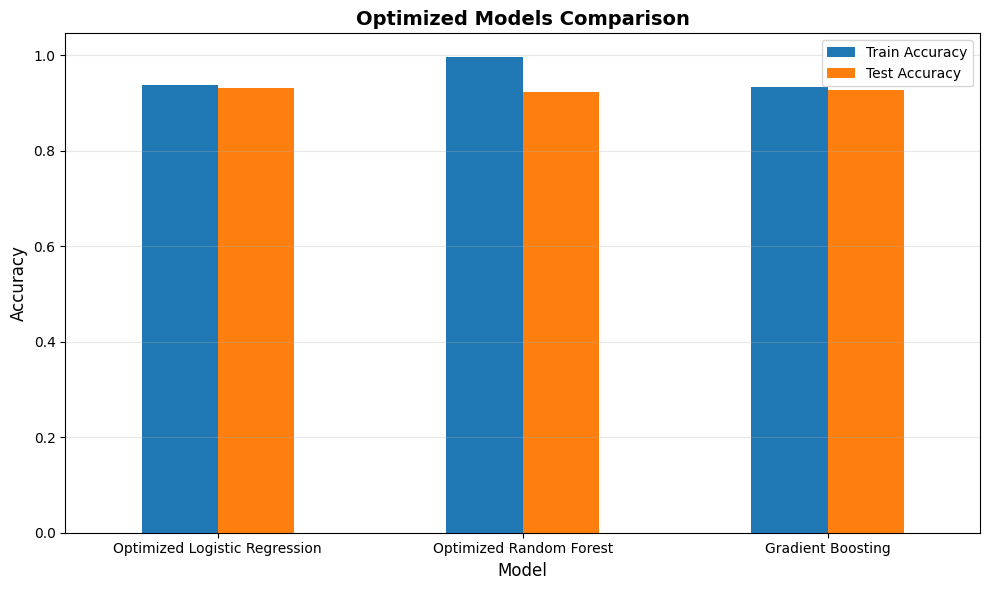

In [11]:
# Evaluate all models
models = {
    'Optimized Logistic Regression': grid_lr.best_estimator_,
    'Optimized Random Forest': random_rf.best_estimator_,
    'Gradient Boosting': gb
}

results = {}

for name, model in models.items():
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    results[name] = {
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc
    }

# Create comparison dataframe
comparison_df = pd.DataFrame(results).T
print("\n📊 Model Comparison:")
print(comparison_df)

# Plot comparison
comparison_df.plot(kind='bar', figsize=(10, 6), rot=0)
plt.title('Optimized Models Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/optimized_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Detailed Evaluation of Best Model

In [12]:
# Find best model
best_model_name = comparison_df['Test Accuracy'].idxmax()
best_model = models[best_model_name]

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test Accuracy: {comparison_df.loc[best_model_name, 'Test Accuracy']:.4f}")

# Comprehensive evaluation
evaluator = ModelEvaluator(
    best_model,
    X_test,
    y_test,
    class_names=['Negative', 'Neutral', 'Positive']  # Adjust as needed
)

evaluator.print_metrics()
evaluator.print_classification_report()


🏆 Best Model: Optimized Logistic Regression
   Test Accuracy: 0.9307

📊 MODEL EVALUATION RESULTS
Accuracy:  0.9307
Precision: 0.9071
Recall:    0.9307
F1-Score:  0.9130

📋 CLASSIFICATION REPORT:

              precision    recall  f1-score   support

    Negative       0.69      0.39      0.50      1061
     Neutral       0.36      0.08      0.13      1156
    Positive       0.94      0.99      0.97     24971

    accuracy                           0.93     27188
   macro avg       0.66      0.49      0.53     27188
weighted avg       0.91      0.93      0.91     27188



✅ Confusion matrix saved to ../reports/figures/confusion_matrix_best.png


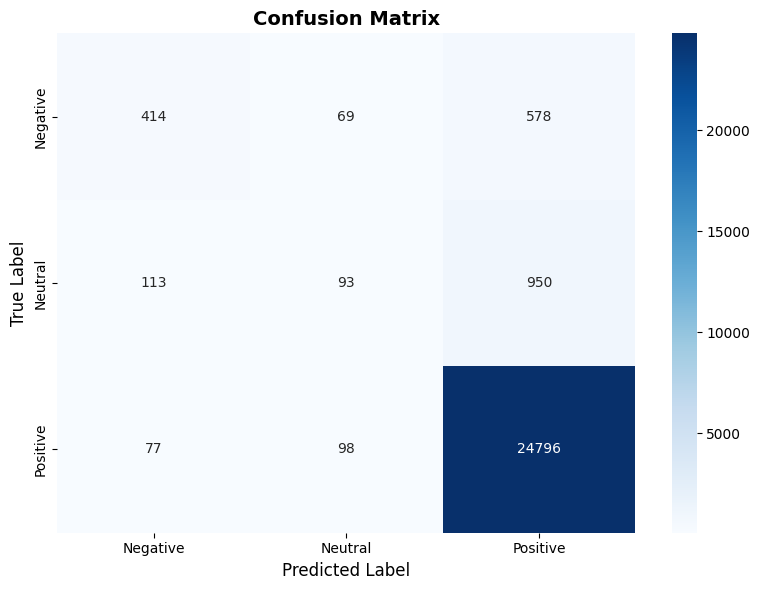

array([[  414,    69,   578],
       [  113,    93,   950],
       [   77,    98, 24796]], dtype=int64)

In [13]:
# Confusion matrix
evaluator.plot_confusion_matrix(save_path='../reports/figures/confusion_matrix_best.png')

## 8. Save Optimized Model

In [17]:
# Save the best model
import joblib

model_path = '../models/optimized_best_model.pkl'
joblib.dump(best_model, model_path)
print(f"✅ Best optimized model saved to {model_path}")

✅ Best optimized model saved to ../models/optimized_best_model.pkl


## 9. Feature Importance (if applicable)

In [18]:
# Get feature importance for tree-based models
if hasattr(best_model, 'feature_importances_'):
    feature_names = extractor.get_feature_names()
    importances = best_model.feature_importances_
    
    # Get top 20 features
    indices = np.argsort(importances)[-20:][::-1]
    top_features = [(feature_names[i], importances[i]) for i in indices]
    
    # Create dataframe
    importance_df = pd.DataFrame(top_features, columns=['Feature', 'Importance'])
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
    plt.title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.savefig('../reports/figures/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n🔝 Top 10 Most Important Features:")
    print(importance_df.head(10).to_string(index=False))
else:
    print("\n⚠️ Selected model doesn't support feature importance.")


⚠️ Selected model doesn't support feature importance.


## 10. Summary

**Optimization Results:**
- Best optimized model: [Name]
- Improvement over baseline: [X%]
- Final test accuracy: [Y%]

**Key Findings:**
- Most important features identified
- Optimal hyperparameters found
- Model ready for deployment

**Next Steps:**
1. Experiment with transformer models (BERT)
2. Implement aspect-based sentiment analysis
3. Build deployment pipeline